# Home Cage Elo Score Calculation

## Importing other Python Libraries/Modules

In [1]:
import re
import os
import sys
from collections import defaultdict
import glob
import warnings
from datetime import datetime
from datetime import timedelta
import ast

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlrd

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
from eloscore import eloscore

In [5]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Experiment
    - Observing fighting behavior between mice in their home cage in different settings. Mice are categorized as winner and loser based on if they initiated the behavior or if they are recieving it. Recording sessions are usually from 30 minutes to a hour with cages of 2 to 6 mice.
- Data
    - Excel spreadsheet of recorded fighting behavior. The relevant columns are those of the "Date" of the recording, the "winner" of the interaction, and the "loser" of the interaction. Each row will be for one interaction between two mice.
    - There is a cage for each sheet of the spreadsheet
    - For each recording session, we will assume that the date will be specified for that first row. We will use this to seperate all the rows into seperate sessions.
- Purpose of this Jupyter Notebook
    - To calculate the Elo Score of each mice after each interaction. The mice start off with an Elo score of 1000. Elo scores are calculated with the formula from here: https://www.omnicalculator.com/sports/elo . Then we will plot the change of elo score across all interactions. With the number of interactions on the X-Axis and the current Elo score on the Y. There will be a line for mice.

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [6]:
input_folder = "./data"

In [7]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[hH]ome*'

- Asking the user what the path to the recording files are, with the option of using wildcards

In [8]:
raw_data_glob_pattern = input("""Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
""")

Type out the path(address) of the raw behavioral recording excel sheets.
Remember that if you are using a relative path, it will be based off of the location of this Jupyter Notebook.

Globbing can also be used if you want to search with a wild card(Capitalization matters). 
i.e. './data/*Home*' will be able to find './data/Homecage_observations.xlsx'

NOTE: If left blank, the path will automatically be guessed off of the default settings 
./data/*Home*


- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have `home` in the file name

In [9]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [10]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    raw_data_file_path = raw_data_files_list[0]

In [11]:
raw_data_file_path

'./data/Home_Cage_Behaviors_Data.xlsx'

## Getting a list of all the sheets

In [12]:
xls = pd.ExcelFile(raw_data_file_path)
raw_data_sheet_names = xls.sheet_names

In [13]:
raw_data_sheet_names

['Legend and Scoring', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

# inputted_sheet_names_string = input("""Type out the name of the sheets that you want to be processed. 
Each name must be put in quotes and seperated by a comma(,). i.e. "CAGE3", "CAGE4"

Alternatively, you can use the index of the list of names above. 
Remember, that Python is zero indexed so the first item will be have the 0 index, second the 1 index, and so on. 
i.e. 1, 2

NOTE: If left blank, all sheets will be used
""")

In [15]:
# Making a list out of the string of inputted sheet names
if inputted_sheet_names_string:
    inputted_sheet_names_string = "[" + inputted_sheet_names_string + "]"
    inputted_sheet_names_list = ast.literal_eval(inputted_sheet_names_string)
# Using all the sheet names if no sheet name is specified
else:
    inputted_sheet_names_list =  raw_data_sheet_names

In [16]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Converting all the numbers into the sheet name that the index of the number corresponds to

In [17]:
for index, sheet in enumerate(inputted_sheet_names_list):
    if str(sheet).isdigit():
        inputted_sheet_names_list[index] =  raw_data_sheet_names[sheet]

In [18]:
inputted_sheet_names_list

['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

- Checking to see if all the sheets are in the excel file

In [19]:
if not set(inputted_sheet_names_list).issubset(raw_data_sheet_names):
    not_included_sheet_names = set(inputted_sheet_names_list) - set(raw_data_sheet_names)
    raise ValueError("All the listed sheet names are not in {}".format(not_included_sheet_names))

## Finding the row for the header

- Showing which columns would be used 

In [20]:
sheet_name_to_header_row = defaultdict(dict)
for sheet in inputted_sheet_names_list:
    print("\nCurrent Sheet Name: {}".format(sheet))
    per_sheet_dataframe = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0)
    # Showing the columns that are chosen with the header being the 0th row
    print("Columns Names: {}".format(per_sheet_dataframe.columns))
    # Show the dataframe that would be created with the header being the 0th row
    print("First few rows of this dataframe:")
    print(pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).head())
    # Allowing the user the choose the row number for the header
    header_row = int(input("""Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on.
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    """).strip())
    if not header_row:
        header_row = 0
    
    column_names = "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).columns])
    if "Unnamed" in column_names:
        raise ValueError("""Not all the cells in the chosen row are filled in.
                         Please choose a row that has the name of the columns
                         
                         The values in this row are: {}""".format(column_names))
    else:
        sheet_name_to_header_row[sheet] = header_row


Current Sheet Name: CAGE1
Columns Names: Index(['Unnamed: 0', 'any details on method ', 'Unnamed: 2', 'Unnamed: 3',
       'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'who gets the point and who loses one (only Fights and Chases get points). The winner gets 1 point and loser -1 ',
       'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')
First few rows of this dataframe:
  Unnamed: 0                          any details on method   \
0   observer                                           notes   
1    Isabel    9:27-9:57am, C57 lots of grooming and rearing   
2        NaN                                             NaN   
3        NaN                                             NaN   
4        NaN                                             NaN   

               Unnamed: 2           Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0  length of observations                 date     cage #     winner   
1                   30min  2022-06-29 00:00:00          1    

Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on.
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    1

Current Sheet Name: CAGE4
Columns Names: Index(['Unnamed: 0',
       'any details on method (e.g. right after tube test or isolation ,etc)',
       'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6',
       'who gets the point and who loses one (only Fights and Chases get point

Type the row number to be used as the header
    (AKA the row with the column name that you want to use.)
    If you want to keep the column names that were displayed, type 0.
    If you want to use a different row, then type the corresponding number. 
    
    The rows displayed in this cell are dataframes created from Pandas. 
    To use the row with the 0 index for column names, type 1. 
    For the row with the 1 index, it will be 2 and so on.
    
    If you are looking at the original spread sheet, remember that Python is zero indexed. 
    So the first row will be 0, second will be 1, and so on. 
    i.e. 1
    
    NOTE: If left blank, the original row that was used will be used.
    1


In [21]:
sheet_name_to_header_row

defaultdict(dict,
            {'CAGE1': 1,
             'CAGE2': 1,
             'CAGE3': 1,
             'CAGE4': 1,
             'CAGE5': 1,
             'CAGE6': 1})

In [22]:
home_cage_observations_df = pd.read_excel(raw_data_file_path, sheet_name=inputted_sheet_names_list[0], header=header_row)

In [23]:
home_cage_observations_df.head()

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3.0,1.0,fs,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,1.0,1.0,2.0,fs,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,1.0,1.0,4.0,ag,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaT,1.0,1.0,4.0,as,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaT,1.0,1.0,2.0,ag,NaN,NaN,NaN,NaN


# Example using One Sheet

## Standarizing the Column

In [24]:
original_column_name_to_standarized = defaultdict(dict)
for col in home_cage_observations_df.columns:
    original_column_name_to_standarized[col] = str(col).lower().strip()

In [25]:
original_column_name_to_standarized

defaultdict(dict,
            {'observer': 'observer',
             'notes': 'notes',
             'length of observations': 'length of observations',
             'date': 'date',
             'cage #': 'cage #',
             'winner': 'winner',
             'loser': 'loser',
             'action': 'action',
             1: '1',
             2: '2',
             3: '3',
             4: '4'})

In [26]:
home_cage_observations_df = home_cage_observations_df.rename(columns=original_column_name_to_standarized)

In [27]:
home_cage_observations_df

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3.0,1.0,fs,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,1.0,1.0,2.0,fs,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,1.0,1.0,4.0,ag,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaT,1.0,1.0,4.0,as,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaT,1.0,1.0,2.0,ag,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
225,NaN,NaN,NaN,NaT,NaN,2.0,1.0,f,-1.0,1.0,NaN,NaN
226,Catalina,"while being food restricted, observed before f...",30 mins,2022-08-09,NaN,2.0,3.0,c,NaN,1.0,-1.0,NaN
227,NaN,NaN,NaN,NaT,NaN,2.0,1.0,c,-1.0,1.0,NaN,NaN
228,Catalina,"while being food restricted, observed before f...",30 mins,2022-08-10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Adding the session number

In [28]:
home_cage_observations_df.head()

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3.0,1.0,fs,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaT,1.0,1.0,2.0,fs,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaT,1.0,1.0,4.0,ag,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaT,1.0,1.0,4.0,as,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaT,1.0,1.0,2.0,ag,NaN,NaN,NaN,NaN


In [29]:
# Allowing the user to choose the row number for the header
session_divider_column = input("""Type the name of the column to be used to divide the rows into sessions. 
Pick a column that has a value in the cell only with the first row of each session.
This is usually the "date" column.

If left blank, the session number will not be added to the spreadsheets and plots will not be divided into sessions.

The available columns are: {}

NOTE: If left blank, "date" will be used as the column
""".format(home_cage_observations_df.columns))

session_divider_column = session_divider_column.lower().strip('"').strip("'").strip()


if not session_divider_column:
    session_divider_column = "date"

if session_divider_column not in home_cage_observations_df.columns:
    raise ValueError("{} is not a column in {}".format(session_divider_column, home_cage_observations_df.columns)) 

Type the name of the column to be used to divide the rows into sessions. 
Pick a column that has a value in the cell only with the first row of each session.
This is usually the "date" column.

If left blank, the session number will not be added to the spreadsheets and plots will not be divided into sessions.

The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'cage #',
       'winner', 'loser', 'action', '1', '2', '3', '4'],
      dtype='object')

NOTE: If left blank, "date" will be used as the column



In [30]:
home_cage_observations_df.dropna(axis=0, subset=session_divider_column)

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4
0,Isabel,"9:27-9:57am, C57 lots of grooming and rearing",30min,2022-06-29,1.0,3.0,1.0,fs,NaN,NaN,NaN,NaN
20,Erika,"10:55 am - 11:25 am, C57",30 min,2022-06-29,1.0,2.0,4.0,as,NaN,NaN,NaN,NaN
36,Meghan,"1:06-1:36PM, lots of grooming due to bleaching...",30min,2022-06-29,1.0,1.0,3.0,fs,NaN,NaN,NaN,NaN
62,Catalina,"C57, 2:30 pm - 3:00 pm",30 minutes,2022-06-30,1.0,2.0,4.0,fs,NaN,NaN,NaN,NaN
75,Naeliz,"C57, 10:58am-11:29am",30 min,2022-07-01,1.0,4.0,3.0,fs,NaN,NaN,NaN,NaN
96,Nancy,1157-1227pm observation after 30 min isolation...,30 min,2022-07-02,1.0,1.0,3.0,fs,NaN,NaN,NaN,NaN
107,Isabel,9:26am C57 observation without mouse 1,30min,2022-07-03,1.0,4.0,2.0,ag,NaN,NaN,NaN,NaN
113,Isabel,"more energetic when the alpha came back, but s...",15min,2022-07-03,1.0,3.0,2.0,fs,NaN,NaN,NaN,NaN
123,erika,"C57, removal of mouse 2, 10 min habituation (1...",30 min,2022-07-04,1.0,1.0,4.0,fs,NaN,NaN,NaN,NaN
144,erika,"C57, reintroduction of mouse 2 into cage, obse...",15 min,2022-07-04,1.0,2.0,3.0,fs,NaN,NaN,NaN,NaN


- Getting the indexes of where each new session starts

In [31]:
home_cage_observations_df.dropna(axis=0, subset=session_divider_column).index

Int64Index([  0,  20,  36,  62,  75,  96, 107, 113, 123, 144, 155, 166, 172,
            187, 194, 201, 210, 226, 228, 229],
           dtype='int64')

In [32]:
session_indexes = home_cage_observations_df.dropna(axis=0, subset=session_divider_column).index

- Adding a column for the session number and then filling all the `NaNs`

In [33]:
home_cage_observations_df = eloscore.add_session_number_column(home_cage_observations_df, session_indexes, session_number_column='session_number')
home_cage_observations_df = home_cage_observations_df.fillna(method='ffill')

## Dropping the rows with only Chase and Fights

In [34]:
# Allowing the user the choose the row number for the header
action_column = input("""Type the name of the column that has the action recorded.

The available columns are: {}

If left blank, the column name will assumed to be "action"
""".format(home_cage_observations_df.columns))

if action_column:
    action_column = action_column.lower().strip()
else: 
    action_column = "action"

Type the name of the column that has the action recorded.

The available columns are: Index(['observer', 'notes', 'length of observations', 'date', 'cage #',
       'winner', 'loser', 'action', '1', '2', '3', '4', 'session_number'],
      dtype='object')

If left blank, the column name will assumed to be "action"



In [35]:
# Allowing the user the choose the row number for the header
elo_counted_actions_string = input("""Type the actions that will be counted towards ELO Score points.
All the available actions: {}
Each action must be put in quotes and seperated by a comma(,). i.e. "f", "c"

NOTE: If left blank, the ELO Score counted actions will assumed to be "f", "c"
""".format(home_cage_observations_df[action_column].unique()))

Type the actions that will be counted towards ELO Score points.
All the available actions: ['fs' 'ag' 'as' 'fs ' 'c' 'f' 'ag ']
Each action must be put in quotes and seperated by a comma(,). i.e. "f", "c"

NOTE: If left blank, the ELO Score counted actions will assumed to be "f", "c"



In [36]:
# Making a list out of the string of inputted sheet names
if elo_counted_actions_string:
    elo_counted_actions_string = "[" + elo_counted_actions_string + "]"
    elo_counted_actions_list = ast.literal_eval(elo_counted_actions_string)
    elo_counted_actions_list = [action.strip() for action in elo_counted_actions_list]
# Using all the sheet names if no sheet name is specified
else:
    elo_counted_actions_list =  ["f", "c"]

In [37]:
elo_counted_actions_list

['f', 'c']

In [38]:
home_cage_observations_df = home_cage_observations_df[home_cage_observations_df[action_column].isin(elo_counted_actions_list)]

In [39]:
home_cage_observations_df.head()

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4,session_number
103,Nancy,lots of self grooming and very little else,30 min,2022-07-02,1.0,1.0,4.0,c,1.0,NaN,NaN,-1.0,6.0
129,erika,they were trying to take bedding from each other,30 min,2022-07-04,1.0,1.0,3.0,f,1.0,NaN,-1.0,-1.0,9.0
132,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,3.0,f,1.0,NaN,-1.0,1.0,9.0
141,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,1.0,f,-1.0,NaN,-1.0,1.0,9.0
194,Jocelyn,Tube Test Training Observations,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0


In [40]:
home_cage_observations_df.shape

(40, 13)

- Making another column for plotting

In [41]:
home_cage_observations_df['session_number_difference'] = home_cage_observations_df['session_number'].diff()

In [42]:
new_session_indexes = home_cage_observations_df[home_cage_observations_df['session_number_difference'] != 0.0]

In [43]:
home_cage_observations_df

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_difference
103,Nancy,lots of self grooming and very little else,30 min,2022-07-02,1.0,1.0,4.0,c,1.0,NaN,NaN,-1.0,6.0,NaN
129,erika,they were trying to take bedding from each other,30 min,2022-07-04,1.0,1.0,3.0,f,1.0,NaN,-1.0,-1.0,9.0,3.0
132,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,3.0,f,1.0,NaN,-1.0,1.0,9.0,0.0
141,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,1.0,f,-1.0,NaN,-1.0,1.0,9.0,0.0
194,Jocelyn,Tube Test Training Observations,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,6.0
195,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2.0,1.0,c,-1.0,1.0,-1.0,1.0,15.0,0.0
196,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,0.0
197,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,0.0
198,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2.0,1.0,c,-1.0,1.0,-1.0,1.0,15.0,0.0
199,Jocelyn,We noticed mice were fighting during the tube ...,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,0.0


In [44]:
new_session_indexes

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_difference
103,Nancy,lots of self grooming and very little else,30 min,2022-07-02,1.0,1.0,4.0,c,1.0,NaN,NaN,-1.0,6.0,NaN
129,erika,they were trying to take bedding from each other,30 min,2022-07-04,1.0,1.0,3.0,f,1.0,NaN,-1.0,-1.0,9.0,3.0
194,Jocelyn,Tube Test Training Observations,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,6.0
201,Albert,We noticed mice were fighting during the tube ...,15min,2022-08-04,1.0,2.0,4.0,c,-1.0,1.0,-1.0,-1.0,16.0,1.0
210,Jocelyn,We noticed mice were fighting during the tube ...,30 mins,2022-08-05,1.0,2.0,3.0,c,-1.0,1.0,-1.0,-1.0,17.0,1.0
226,Catalina,"while being food restricted, observed before f...",30 mins,2022-08-09,1.0,2.0,3.0,c,-1.0,1.0,-1.0,-1.0,18.0,1.0
228,Catalina,"while being food restricted, observed before f...",30 mins,2022-08-10,1.0,2.0,1.0,c,-1.0,1.0,-1.0,-1.0,19.0,1.0
229,Catalina,"while being food restricted, observed 10 min a...",30 mins,2022-08-11,1.0,3.0,1.0,f,-1.0,1.0,1.0,-1.0,20.0,1.0


## Calculating ELO Score

- Example calculation

In [45]:
eloscore.calculate_elo_score(subject_elo_score=1000, agent_elo_score=2000)

1020

## Get the Elo score for all the events

In [46]:
home_cage_observations_df.head()

,observer,notes,length of observations,date,cage #,winner,loser,action,1,2,3,4,session_number,session_number_difference
103,Nancy,lots of self grooming and very little else,30 min,2022-07-02,1.0,1.0,4.0,c,1.0,NaN,NaN,-1.0,6.0,NaN
129,erika,they were trying to take bedding from each other,30 min,2022-07-04,1.0,1.0,3.0,f,1.0,NaN,-1.0,-1.0,9.0,3.0
132,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,3.0,f,1.0,NaN,-1.0,1.0,9.0,0.0
141,erika,trying to take bedding from the other,30 min,2022-07-04,1.0,4.0,1.0,f,-1.0,NaN,-1.0,1.0,9.0,0.0
194,Jocelyn,Tube Test Training Observations,15min,2022-07-07,1.0,2.0,1.0,f,-1.0,1.0,-1.0,1.0,15.0,6.0


In [47]:
eloscore.update_elo_score(winner_id="A", loser_id="B")

defaultdict(<function eloscore.eloscore.update_elo_score.<locals>.<lambda>()>,
            {'A': 1010.0, 'B': 990.0})

- Function that creates a dictionary that has the original/updated elo score for each event

In [48]:
winner_column = input("""Type the name of the column of the subject that has won the interaction.
i.e. "winner"

Note: If left blank, the "winner" will be used as the column
""".format(home_cage_observations_df.columns))

if not winner_column:
    winner_column = "winner"

Type the name of the column of the subject that has won the interaction.
i.e. "winner"

Note: If left blank, the "winner" will be used as the column



In [49]:
loser_column = input("""Type the name of the column of the subject that has won the interaction.
i.e. "loser"

Note: If left blank, the "loser" will be used as the column
""".format(home_cage_observations_df.columns))

if not loser_column:
    loser_column = "loser"

Type the name of the column of the subject that has won the interaction.
i.e. "loser"

Note: If left blank, the "loser" will be used as the column



In [50]:
home_cage_observations_df.columns

Index(['observer', 'notes', 'length of observations', 'date', 'cage #',
       'winner', 'loser', 'action', '1', '2', '3', '4', 'session_number',
       'session_number_difference'],
      dtype='object')

In [51]:
columns_to_keep_string = input("""Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

All the available actions: {}
Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

NOTE: If left blank, all the columns will be kept
""".format(home_cage_observations_df.columns))


Type all the columns that will be copied from the original dataframe to the ELO Score calculated dataframe. 

All the available actions: Index(['observer', 'notes', 'length of observations', 'date', 'cage #',
       'winner', 'loser', 'action', '1', '2', '3', '4', 'session_number',
       'session_number_difference'],
      dtype='object')
Each column must be put in quotes and seperated by a comma(,). i.e. 'length of observations', 'date', 'cage #'

NOTE: If left blank, all the columns will be kept



In [52]:
# Making a list out of the string of inputted sheet names
if columns_to_keep_string:
    columns_to_keep_string = "[" + columns_to_keep_string + "]"
    columns_to_keep_list = ast.literal_eval(columns_to_keep_string)
# Using all the sheet names if no sheet name is specified
else:
    columns_to_keep_list =  sorted(list(set(home_cage_observations_df.columns) - set([winner_column]) - set([loser_column])))

In [53]:
columns_to_keep_list

['1',
 '2',
 '3',
 '4',
 'action',
 'cage #',
 'date',
 'length of observations',
 'notes',
 'observer',
 'session_number',
 'session_number_difference']

In [54]:
index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=home_cage_observations_df, winner_column=winner_column, loser_column=loser_column, additional_columns=columns_to_keep_list + ["session_number_difference"])

In [55]:
index_to_elo_score_and_meta_data[0]

{'total_match_number': 1,
 'subject_id': 1.0,
 'agent_id': 4.0,
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1,
 '1': 1.0,
 '2': nan,
 '3': nan,
 '4': -1.0,
 'action': 'c',
 'cage #': 1.0,
 'date': Timestamp('2022-07-02 00:00:00'),
 'length of observations': '30 min',
 'notes': 'lots of self grooming and very little else',
 'observer': 'Nancy',
 'session_number': 6.0,
 'session_number_difference': nan}

- Turning the dictionary into a dataframe

In [56]:
home_cage_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [57]:
home_cage_elo_score_df.head()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,1,2,3,4,action,cage #,date,length of observations,notes,observer,session_number,session_number_difference
0,1,1.0,4.0,1000.0,1010.0,1,1.0,NaN,NaN,-1.0,c,1.0,2022-07-02,30 min,lots of self grooming and very little else,Nancy,6.0,NaN
1,1,4.0,4.0,1000.0,990.0,1,1.0,NaN,NaN,-1.0,c,1.0,2022-07-02,30 min,lots of self grooming and very little else,Nancy,6.0,NaN
2,2,1.0,3.0,1010.0,1019.7,1,1.0,NaN,-1.0,-1.0,f,1.0,2022-07-04,30 min,they were trying to take bedding from each other,erika,9.0,3.0
3,2,3.0,3.0,1000.0,990.3,1,1.0,NaN,-1.0,-1.0,f,1.0,2022-07-04,30 min,they were trying to take bedding from each other,erika,9.0,3.0
4,3,4.0,3.0,990.0,1000.0,1,1.0,NaN,-1.0,1.0,f,1.0,2022-07-04,30 min,trying to take bedding from the other,erika,9.0,0.0


In [58]:
home_cage_elo_score_df.tail()

,total_match_number,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss,1,2,3,4,action,cage #,date,length of observations,notes,observer,session_number,session_number_difference
75,38,1.0,1.0,921.2,917.6,1,-1.0,1.0,-1.0,-1.0,c,1.0,2022-08-09,30 mins,"while being food restricted, observed before f...",Catalina,18.0,0.0
76,39,2.0,1.0,1191.1,1194.5,1,-1.0,1.0,-1.0,-1.0,c,1.0,2022-08-10,30 mins,"while being food restricted, observed before f...",Catalina,19.0,1.0
77,39,1.0,1.0,917.6,914.2,1,-1.0,1.0,-1.0,-1.0,c,1.0,2022-08-10,30 mins,"while being food restricted, observed before f...",Catalina,19.0,1.0
78,40,3.0,1.0,913.7,923.7,1,-1.0,1.0,1.0,-1.0,f,1.0,2022-08-11,30 mins,"while being food restricted, observed 10 min a...",Catalina,20.0,1.0
79,40,1.0,1.0,914.2,904.2,1,-1.0,1.0,1.0,-1.0,f,1.0,2022-08-11,30 mins,"while being food restricted, observed 10 min a...",Catalina,20.0,1.0


In [59]:
home_cage_elo_score_df.groupby("subject_id").count()

,total_match_number,agent_id,original_elo_score,updated_elo_score,win_draw_loss,1,2,3,4,action,cage #,date,length of observations,notes,observer,session_number,session_number_difference
subject_id,,,,,,,,,,,,,,,,,
1.0,19,19,19,19,19,19,16,18,19,19,19,19,19,19,19,19,18
2.0,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
3.0,16,16,16,16,16,16,14,16,16,16,16,16,16,16,16,16,16
4.0,10,10,10,10,10,10,7,9,10,10,10,10,10,10,10,10,9


# Plotting the Elo Score by match number

In [91]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

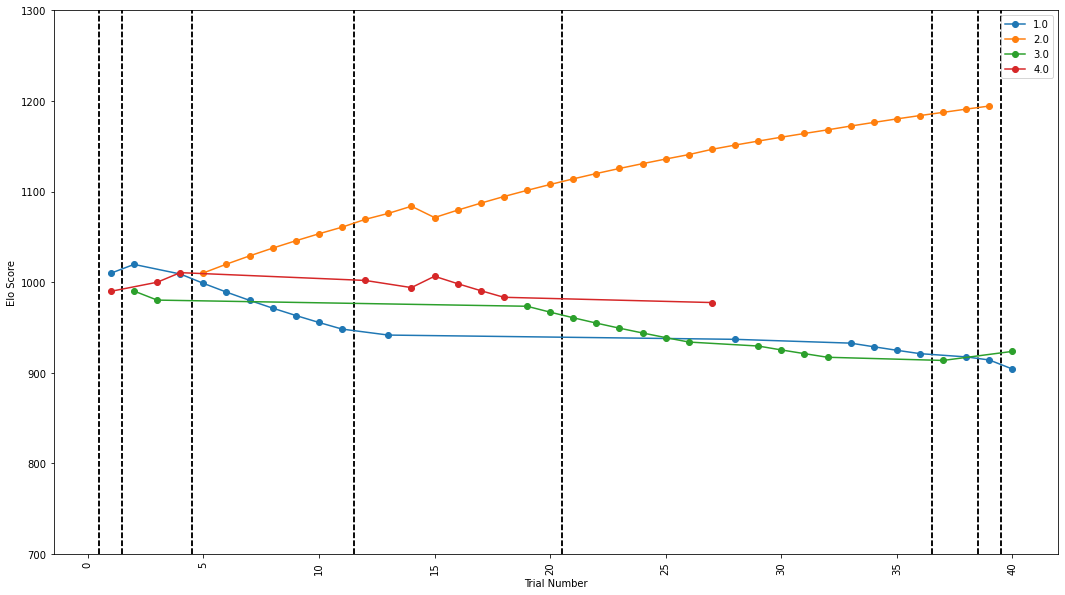

In [92]:
fig, ax = plt.subplots()

# Drawing vertical lines that represent when each session begins
for index, row in home_cage_elo_score_df[home_cage_elo_score_df['session_number_difference'] != 0.0].iterrows():
    # Offsetting by 0.5 to avoid drawing the line on the dot
    plt.vlines(x=[row["total_match_number"] - 0.5], ymin=700, ymax=1300, colors='black', linestyle='dashed')

# Drawing a line for each subject
for subject in sorted(home_cage_elo_score_df["subject_id"].unique()):
    # Getting all the rows with the current subject
    subject_df = home_cage_elo_score_df[home_cage_elo_score_df["subject_id"] == subject]
    # Making the dates into days after the first session by subtracting all the dates by the first date
    plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

# Labeling the X/Y Axis and the title
ax.set_xlabel("Trial Number")
ax.set_ylabel("Elo Score")
# ax.set_title("Elo Score for Home Cage Observation: Cage {}".format(cage))
# To show the legend
ax.legend()
plt.xticks(rotation=90)
plt.ylim(700, 1300) 
plt.show()



# Calculate the Elo Score for all sheets

In [63]:
xls = pd.ExcelFile(raw_data_file_path)
sheets = xls.sheet_names

In [64]:
sheets

['Legend and Scoring', 'CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6']

In [65]:
sheet_to_data_frame = defaultdict(dict)
for sheet in sheets[:]:
    try:
        # Seeing if "Unnamed" is in any of the cells for the 0th row
        if "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=0).columns]):
            header_row = 0
        # Seeing if "Unnamed" is in any of the cells for the 1st row
        elif "Unnamed" not in "".join([str(col) for col in pd.read_excel(raw_data_file_path, sheet_name=sheet, header=1).columns]):
            header_row = 1
        else:
            header_row = 0
            warnings.warn("""Both the 0th and the 1st row have cells with blank values. This means that that these rows can not be used as headers. Please change the row number to the header""")

        
        
        
        sheet_to_data_frame[sheet]["recording_data_frame"] = pd.read_excel(raw_data_file_path, sheet_name=sheet, header=header_row).copy()

        original_column_name_to_standarized = defaultdict(dict)
        for col in sheet_to_data_frame[sheet]["recording_data_frame"].columns:
            original_column_name_to_standarized[col] = str(col).lower().strip()

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].rename(columns=original_column_name_to_standarized)

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(subset=["winner"])

        # Adding the session numbers as a column
        session_indexes = sheet_to_data_frame[sheet]["recording_data_frame"].dropna(axis=0, subset="date").index
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes)
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].fillna(method='ffill')
        sheet_to_data_frame[sheet]["recording_data_frame"] = eloscore.add_session_number_column(sheet_to_data_frame[sheet]["recording_data_frame"], session_indexes, session_number_column="session_number_plotting")

        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"][sheet_to_data_frame[sheet]["recording_data_frame"]["action"].isin(["f", "c"])]

        # Splitting all the rows with commas in the ID
        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(str)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(str)

        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].str.split(",")
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("winner").reset_index(drop=True)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].str.split(",")
        sheet_to_data_frame[sheet]["recording_data_frame"] = sheet_to_data_frame[sheet]["recording_data_frame"].explode("loser").reset_index(drop=True)

        sheet_to_data_frame[sheet]["recording_data_frame"]["winner"] = sheet_to_data_frame[sheet]["recording_data_frame"]["winner"].astype(float).astype(int).astype(str)
        sheet_to_data_frame[sheet]["recording_data_frame"]["loser"] = sheet_to_data_frame[sheet]["recording_data_frame"]["loser"].astype(float).astype(int).astype(str)

        # Calculating the Elo Score    
        index_to_elo_score_and_meta_data = eloscore.iterate_elo_score_calculation_for_data_frame(data_frame=sheet_to_data_frame[sheet]["recording_data_frame"], \
                                                                                                                   winner_column="winner", loser_column="loser", additional_columns=["date", "session_number", "session_number_plotting"])
        sheet_to_data_frame[sheet]["elo_score_data_frame"] = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")
    except:
        print(sheet)

        warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")
        sheet_to_data_frame.pop(sheet, None)

Legend and Scoring


/tmp/ipykernel_2057/4054884481.py:54: UserWarning: Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored
  warnings.warn("Please update the formatting for the sheet with the above name, or continue if this sheet is being ignored")


In [66]:
sheet_to_data_frame.keys()

dict_keys(['CAGE1', 'CAGE2', 'CAGE3', 'CAGE4', 'CAGE5', 'CAGE6'])

## Saving the Elo Score Dataframes

- Create folders to save processed data

- Adding the cage information for each cage

In [67]:
for key, value in sheet_to_data_frame.items():    
    cage_number = re.findall(r'\d+', key)[0]
    sheet_to_data_frame[key]["elo_score_data_frame"]["cage"] = cage_number
    sheet_to_data_frame[key]["elo_score_data_frame"]["id_with_cage_number"] = sheet_to_data_frame[key]["elo_score_data_frame"]["subject_id"].apply(lambda x: cage_number + "." + x)
    sheet_to_data_frame[key]["elo_score_data_frame"]["experiment_type"] = "home_cage_observation"

In [68]:
all_sheet_elo_scord_df_list = []
for key, value in sheet_to_data_frame.items():    
    all_sheet_elo_scord_df_list.append(sheet_to_data_frame[key]["elo_score_data_frame"])

In [69]:
all_sheet_elo_scord_df_combined = pd.concat(all_sheet_elo_scord_df_list)

In [70]:
all_sheet_elo_scord_df_combined["id_with_cage_number"].unique()

array(['1.1', '1.4', '1.3', '1.2', '2.3', '2.4', '2.2', '2.1', '3.1',
       '3.3', '3.2', '3.4', '4.1', '4.3', '4.4', '4.2', '5.3', '5.1',
       '5.4', '5.2', '6.4', '6.2', '6.1', '6.3'], dtype=object)

In [71]:
id_to_final_elo_score_dict = defaultdict(dict)
for id_with_cage_number in all_sheet_elo_scord_df_combined["id_with_cage_number"].unique():
    per_subject_df = all_sheet_elo_scord_df_combined[all_sheet_elo_scord_df_combined["id_with_cage_number"] == id_with_cage_number]
    id_to_final_elo_score_dict[id_with_cage_number]["final_elo_score"] = per_subject_df.iloc[-1]["updated_elo_score"]

In [72]:
id_to_final_elo_score_df = pd.DataFrame.from_dict(id_to_final_elo_score_dict, orient="index")
id_to_final_elo_score_df["experiment_type"] = "home_cage_observation"

In [73]:
id_to_final_elo_score_df["id_with_cage_number"] = id_to_final_elo_score_df.index
id_to_final_elo_score_df = id_to_final_elo_score_df.reset_index(drop=True)

In [74]:
id_to_final_elo_score_df.head()

,final_elo_score,experiment_type,id_with_cage_number
0,907.5,home_cage_observation,1.1
1,1191.1,home_cage_observation,1.2
2,923.8,home_cage_observation,1.3
3,977.6,home_cage_observation,1.4
4,882.7,home_cage_observation,2.1


# Making plots for all sheets

- Getting the dates the files were being recorded to use for the file name

In [75]:
sheets[1]

'CAGE1'

In [76]:
earliest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].min()).split()[0]

In [77]:
latest_date = str(sheet_to_data_frame[sheets[1]]["recording_data_frame"]["date"].max()).split()[0]

In [78]:
earliest_date

'2022-07-02'

In [79]:
latest_date

'2022-08-11'

- Getting the cage numbers

In [80]:
all_cages = "_".join(sorted([sheet.lower().strip("cage").strip() for sheet in sheet_to_data_frame.keys()]))

In [81]:
all_cages

'1_2_3_4_5_6'

In [82]:
output_directory = "./proc/plots/home_cage_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [83]:
output_directory

'./proc/plots/home_cage_elo_score/cage_1_2_3_4_5_6_date_2022-07-02_2022-08-11'

In [84]:
os.makedirs(output_directory, exist_ok=True)

CAGE1


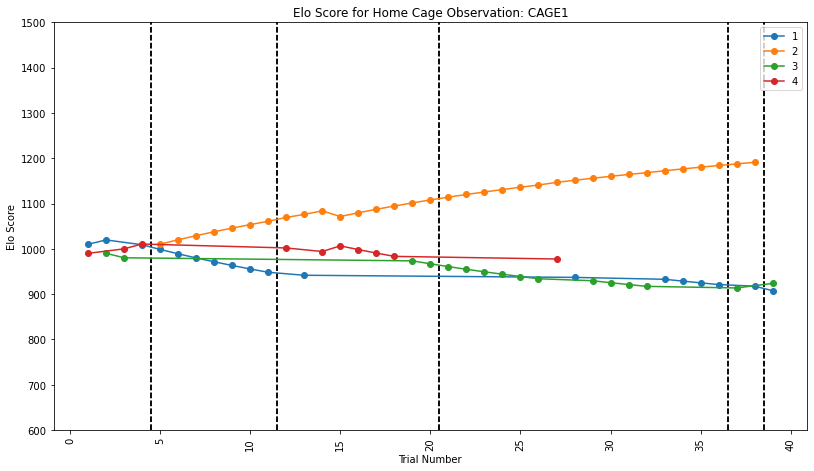

CAGE2


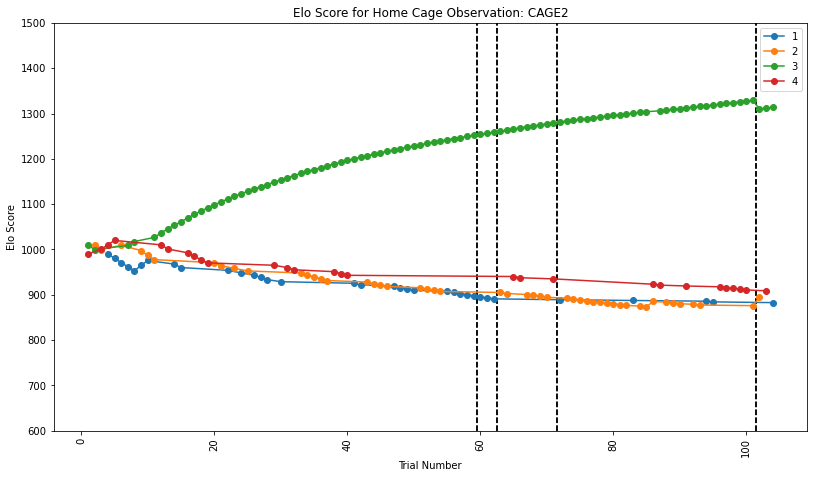

CAGE3


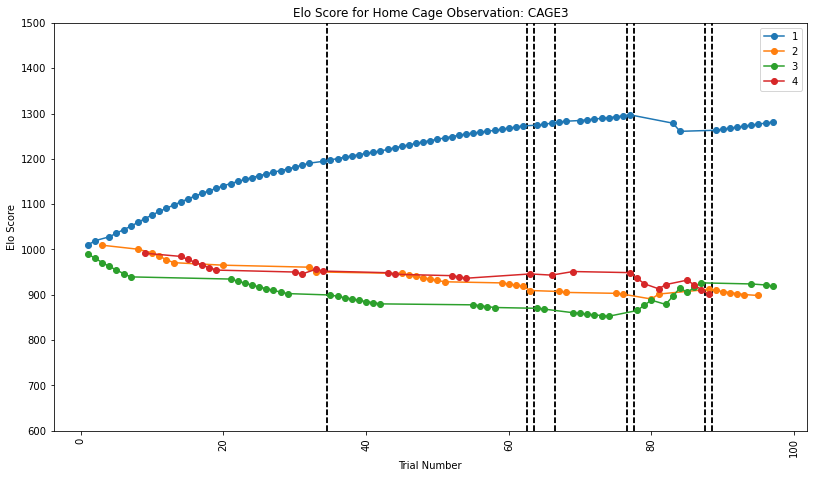

CAGE4


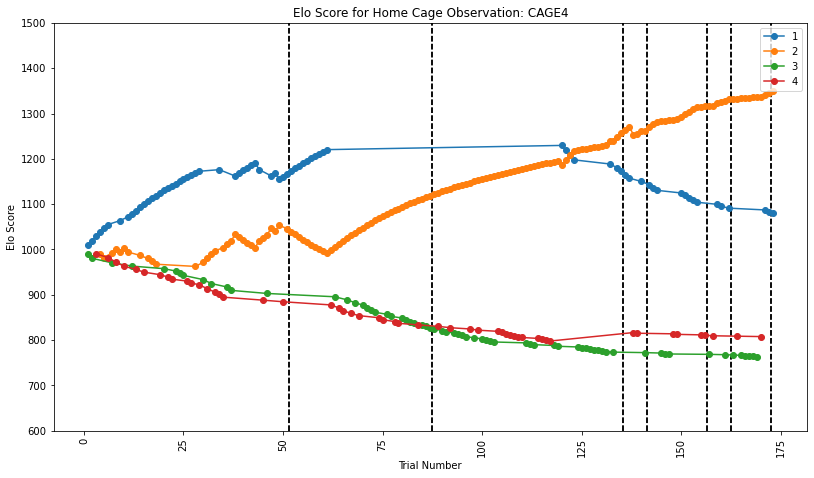

CAGE5


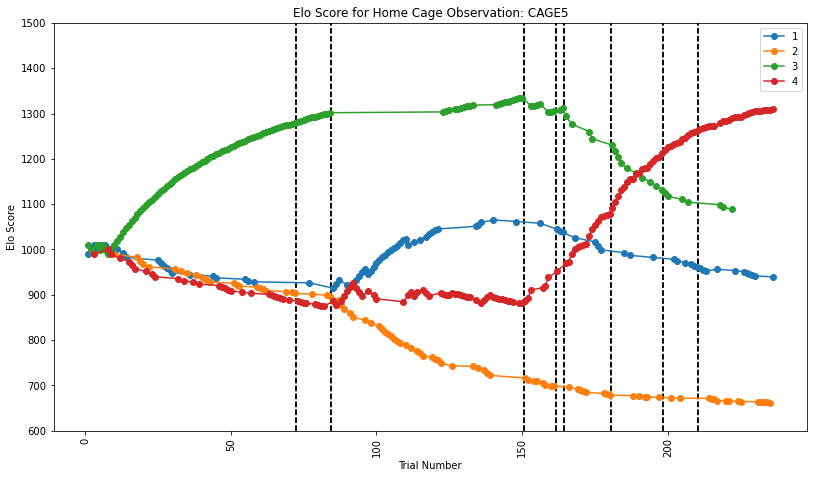

CAGE6


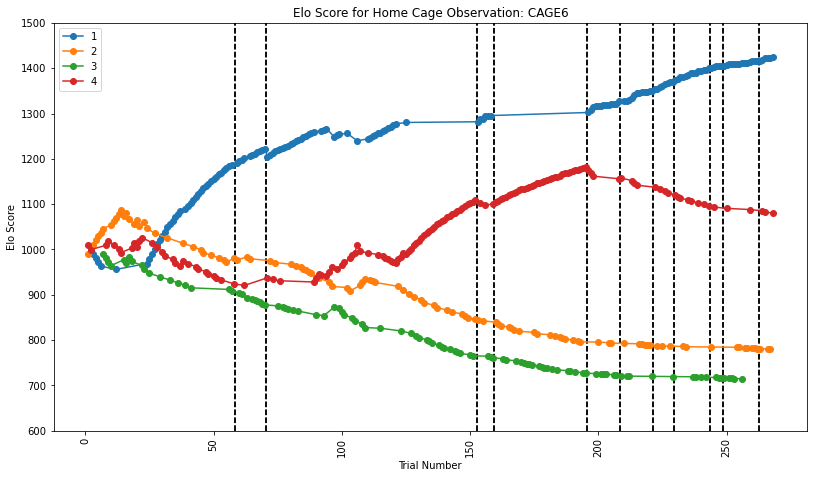

In [85]:
for key, value in sheet_to_data_frame.items():
    plt.rcParams["figure.figsize"] = (13.5,7.5)
    print(key)
    elo_score_data_frame = value["elo_score_data_frame"]
    fig, ax = plt.subplots()

    # Drawing vertical lines that represent when each session begins
    for index, row in elo_score_data_frame.dropna(subset=["session_number_plotting"]).iterrows():
        # Offsetting by 0.5 to avoid drawing the line on the dot
        plt.vlines(x=[row["total_match_number"] - 0.5], ymin=600, ymax=1500, colors='black', linestyle='dashed')

    # Drawing a line for each subject
    for subject in sorted(elo_score_data_frame["subject_id"].astype(str).unique()):
        # Getting all the rows with the current subject
        subject_df = elo_score_data_frame[elo_score_data_frame["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        plt.plot(subject_df["total_match_number"], subject_df["updated_elo_score"], '-o', label=subject)

    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Home Cage Observation: {}".format(key))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(600, 1500) 
    
    
    file_name = "home_cage_elo_score_{}_date_{}_{}.png".format(key, earliest_date, latest_date)
    plt.savefig(os.path.join(output_directory, file_name))
    
    plt.show()

# Saving the Dataframes

In [86]:
output_directory = "./proc/elo_score_spread_sheets/home_cage_observation_elo_score/cage_{}_date_{}_{}".format(all_cages, earliest_date, latest_date)

In [87]:
output_directory

'./proc/elo_score_spread_sheets/home_cage_observation_elo_score/cage_1_2_3_4_5_6_date_2022-07-02_2022-08-11'

In [88]:
os.makedirs(output_directory, exist_ok=True)

In [89]:
file_name = "home_cage_observation_elo_score_history_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
all_sheet_elo_scord_df_combined.to_csv(os.path.join(output_directory, file_name))

In [90]:
file_name = "home_cage_observation_final_elo_score_cages_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date)
id_to_final_elo_score_df.to_csv(os.path.join(output_directory, file_name))